# Training a neural network on MNIST with Keras

This simple example demonstrate how to plug TFDS into a Keras model.

**Note: This is a modified version for Intel AI Online Labs!**


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Step 0: Setup environment

- Set number of threads to use
- Use the Intel related "tuning knobs"
- Show available devices for computation
- Use Tensorflow 2.0 semantic

In [1]:
import os
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

NUM_PARALLEL_EXEC_UNITS=1
tf.config.threading.set_intra_op_parallelism_threads(NUM_PARALLEL_EXEC_UNITS)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.set_soft_device_placement(True)

os.environ["OMP_NUM_THREADS"] = "{}".format(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "30"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

physical_devices = tf.config.list_physical_devices()
print(physical_devices)

tfds.disable_progress_bar()
tf.enable_v2_behavior()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]


## Step 1: Create your input pipeline

Build efficient input pipeline using advices from:
* [TFDS performance guide](https://www.tensorflow.org/datasets/performances)
* [tf.data performance guide](https://www.tensorflow.org/guide/data_performance#optimize_performance)


### Load MNIST

Load with the following arguments:

* `shuffle_files`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised`: Returns tuple `(img, label)` instead of dict `{'image': img, 'label': label}`

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset mnist downloaded and prepared to /home/jovyan/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Build training pipeline

Apply the following transormations:

* `ds.map`: TFDS provide the images as tf.uint8, while the model expect tf.float32, so normalize images
* `ds.cache` As the dataset fit in memory, cache before shuffling for better performance.<br/>
__Note:__ Random transformations should be applied after caching
* `ds.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For bigger datasets which do not fit in memory, a standard value is 1000 if your system allows it.
* `ds.batch`: Batch after shuffling to get unique batches at each epoch.
* `ds.prefetch`: Good practice to end the pipeline by prefetching [for performances](https://www.tensorflow.org/guide/data_performance#prefetching).

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

### Inspect the data set

Display individual MNIST samples and their labels.

**Note:** Rerun the cell to see different samples. This is due to shuffling of the data in the 'ds_train' dataset every time it is accessed (iterated).

#### **Label:** 1

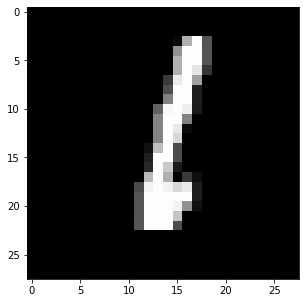

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# Show one image in ds_train (Note that rerunning reshuffles!)
batch = 40 # Can be any batch
idx = 40   # Can be any index within each batch
for x, y in ds_train:
    if batch == 0:
        img = x[idx][:, :,0]
        img = np.stack((img,)*3, axis=-1)
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        display(Markdown("#### **Label:** {}".format(y[idx])))
        plt.show()
        break
    else:
        batch -= 1

### Build evaluation pipeline

Testing pipeline is similar to the training pipeline, with small differences:

 * No `ds.shuffle()` call
 * Caching is done after batching (as batches can be the same between epoch)

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Step 2: Create and train the model

### Start Tensorboard
We use Tensorboard to minitor the training/validation progress over epochs.

In [6]:
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)

%reload_ext tensorboard
%tensorboard --logdir {log_dir} --host 0.0.0.0 --port 6006

# Alternative way to display Tensorboard
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000) 

### Connect input pipeline and train

In [7]:
import os
import time
import datetime

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1)

time_s = time.time()
model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test,
    callbacks=[tensorboard_callback]
)
print("Runtime: {}".format(time.time() - time_s))

Epoch 1/50
469/469 [==============================] - 8s 16ms/step - loss: 0.3639 - accuracy: 0.8992 - val_loss: 0.1907 - val_accuracy: 0.9443
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1634 - accuracy: 0.9536 - val_loss: 0.1331 - val_accuracy: 0.9614
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1177 - accuracy: 0.9662 - val_loss: 0.1025 - val_accuracy: 0.9695
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0910 - accuracy: 0.9737 - val_loss: 0.0903 - val_accuracy: 0.9725
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0719 - accuracy: 0.9800 - val_loss: 0.0813 - val_accuracy: 0.9753
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0598 - accuracy: 0.9825 - val_loss: 0.0720 - val_accuracy: 0.9774
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0510 - accuracy: 0.9852 - val_loss: 0.0709 - val_accuracy: 0.9776
Epoch

### Evaluate with confusion matrix

Here we print the confusion matrix over all predictions from the validation data set.

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Confusion matrix, without normalization


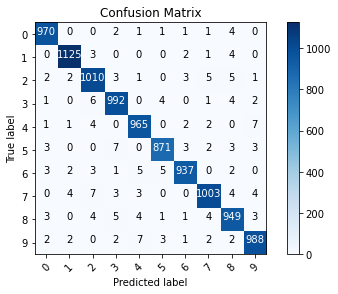

In [8]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix'):
    import itertools
    import matplotlib.pyplot as plt
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_true = np.empty((0,), dtype=int, order='C')
for test_x, test_y in ds_test:
    y_true = np.concatenate((y_true, test_y.numpy()))
    
y_pred = ynew = model.predict_classes(ds_test, batch_size=None)
cm = confusion_matrix(y_true, y_pred)
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Show some samples that failed in validation.

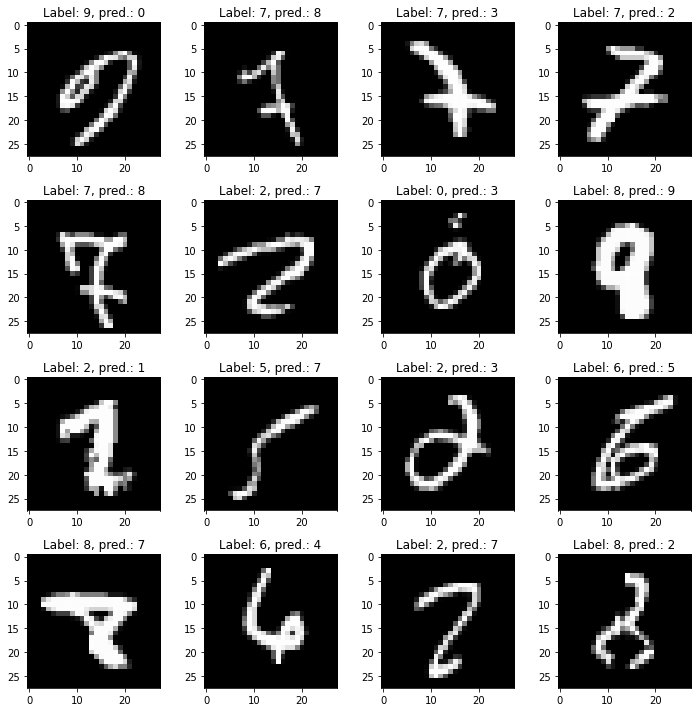

In [9]:
cur_image = 0
num_images = 16
fig = plt.figure(figsize=(10,10))

for (test_val, pred_y) in zip(ds_test.unbatch(), y_pred):
    if  test_val[1].numpy() != pred_y: # Only where prediction and ground truth are different!
        cur_image += 1
        img = test_val[0][:, :,0]
        img = np.stack((img,)*3, axis=-1)
        ax = fig.add_subplot(4, 4 ,cur_image)
        im = ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.set_title("Label: {}, pred.: {}".format(test_val[1].numpy(), pred_y))


        if num_images == cur_image:
            break
plt.tight_layout()
plt.show()